```
         Copyright Rein Halbersma 2020-2021.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Chapter 5 Monte Carlo Methods

## 5.1 Monte Carlo Prediction

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from doctrina.algorithms import dp, mc, td
from doctrina.spaces import shape, size
from doctrina.utils import one_hot_encode
import gym_blackjack_v1 as bj

env = gym.make('Blackjack-v1')
env.seed(47110815)

[47110815]

**Example 5.1: Blackjack**

In [2]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
stand_on_20 = np.full(env.observation_shape, bj.Action.HIT)
stand_on_20[bj.Hand.H20:(bj.Hand.H21 + 1), :] = bj.Action.STAND
stand_on_20[bj.Hand.S20:(bj.Hand.BJ  + 1), :] = bj.Action.STAND
stand_on_20 = stand_on_20.reshape(env.nS)

In [3]:
# In any event, after 500,000 games the value function is very well approximated.
runs = [ 10_000, 500_000 ]
Vs, *_ = zip(*[ 
    #mc.V_predict_ev(env, stand_on_20, num_episodes, format='deter')
    td.V_predict(env, stand_on_20, num_episodes, format='deter') 
    for num_episodes in runs 
])

100%|██████████| 500000/500000 [00:08<00:00, 58673.97it/s]


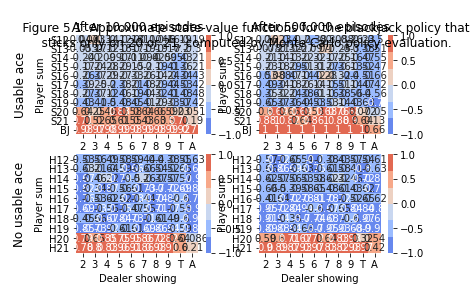

In [4]:
options = {
    'vmin': min(env.reward_range), 
    'vmax': max(env.reward_range), 
    'cmap': sns.color_palette('coolwarm'), 
    'center': 0.,
    'annot': True, 
    'xticklabels': bj.card_labels
}

hands = [
    np.arange(bj.Hand.S12, bj.Hand.BJ  + 1),
    np.arange(bj.Hand.H12, bj.Hand.H21 + 1)
]

yticklabels = [ 
    np.array(bj.hand_labels)[hands[no_usable_ace]] 
    for no_usable_ace in range(2)
]

axopts = {
    'xlabel': 'Dealer showing',
    'ylabel': 'Player sum'
}

fig, axes = plt.subplots(nrows=2, ncols=len(runs))
fig.suptitle(
    """
    Figure 5.1: Approximate state-value functions for the blackjack policy that
    sticks only on 20 or 21, computed by Monte Carlo policy evaluation.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ f'After {episodes:,} episodes' for episodes in runs ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    for r, _ in enumerate(runs):
        sns.heatmap(Vs[r].reshape(env.observation_shape)[h, :], yticklabels=yticklabels[i], ax=axes[i, r], **options).set(**axopts)
plt.show()

In [5]:
pd.DataFrame(
    Vs[1].reshape(env.observation_shape),
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.4947,-0.4911,-0.5534,-0.4442,-0.4821,-0.4630,-0.5631,-0.4107,-0.4241,-0.6577
H5,-0.4412,-0.4780,-0.5302,-0.4029,-0.3805,-0.3927,-0.5139,-0.5356,-0.5625,-0.7208
H6,-0.4619,-0.4470,-0.4384,-0.4135,-0.4475,-0.4076,-0.5175,-0.5011,-0.5554,-0.6765
H7,-0.4699,-0.6022,-0.6183,-0.5391,-0.6066,-0.4557,-0.5020,-0.6575,-0.6486,-0.6720
H8,-0.6241,-0.6122,-0.5197,-0.5567,-0.5092,-0.5434,-0.4489,-0.5104,-0.6015,-0.6960
H9,-0.3782,-0.6323,-0.6207,-0.3968,-0.5758,-0.4498,-0.5360,-0.2540,-0.4170,-0.7482
H10,-0.0095,-0.0803,-0.1596,-0.0558,-0.0769,0.2094,0.2868,-0.0427,-0.2170,-0.4317
H11,-0.2254,-0.0053,-0.0912,0.2311,-0.1099,-0.4484,0.4903,-0.1330,0.1731,-0.2731
H12,-0.5747,-0.7167,-0.6539,-0.5381,-0.7033,-0.3833,-0.4287,-0.5744,-0.5374,-0.6113
H13,-0.6636,-0.8572,-0.6941,-0.6322,-0.7511,-0.6092,-0.5837,-0.4106,-0.7993,-0.6255


## 5.3 Monte Carlo Control

**Example 5.3: Solving Blackjack**

In [6]:
num_episodes = 500_000
#Q, N = mc.Q_control_ev(env, num_episodes, policy0=one_hot_encode(stand_on_20))
Q = td.Q_learning(env, num_episodes)
policy = Q.argmax(axis=-1)
V = Q.max(axis=-1)

100%|██████████| 500000/500000 [00:29<00:00, 17181.15it/s]


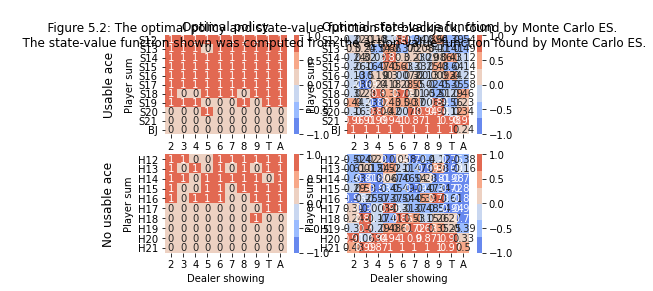

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(
    """
    Figure 5.2: The optimal policy and state-value function for blackjack, found by Monte Carlo ES. 
    The state-value function shown was computed from the action-value function found by Monte Carlo ES.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ 'Optimal policy', 'Optimal state-value function' ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    sns.heatmap(policy.reshape(env.observation_shape)[h, :], yticklabels=yticklabels[i], ax=axes[i, 0], **options).set(**axopts)
    sns.heatmap(     V.reshape(env.observation_shape)[h, :], yticklabels=yticklabels[i], ax=axes[i, 1], **options).set(**axopts)
plt.show()

In [8]:
pd.DataFrame(
    V.reshape(env.observation_shape), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,0.0060,-0.2570,-0.1112,-0.0257,-0.3954,-0.3554,-0.5672,-0.4105,-0.1098,-0.3040
H5,-0.2959,0.1427,0.5671,0.1629,0.4327,0.1506,-0.6321,-0.2832,-0.5633,-0.3754
H6,-0.7327,-0.3506,0.3444,0.1204,-0.0526,0.2628,0.2278,0.1979,-0.5583,-0.4200
H7,-0.3734,0.8355,-0.6907,0.2699,-0.4959,0.1595,-0.5108,-0.3077,-0.5134,-0.5938
H8,-0.0262,0.1093,0.2732,0.4842,-0.2869,0.0593,0.2012,-0.0280,-0.5727,-0.5606
H9,-0.0126,-0.6866,0.1881,0.2957,-0.2533,-0.4757,0.1717,0.1892,-0.4844,-0.2997
H10,0.3232,0.8309,-0.0933,0.4377,0.7947,-0.4361,0.1074,-0.7879,-0.5169,-0.2777
H11,0.6336,0.1608,0.7030,0.4904,0.1179,0.3245,-0.5187,-0.4701,0.3811,-0.1199
H12,-0.5189,-0.4233,0.2227,-0.7771,0.0580,-0.7152,-0.4001,-0.1187,-0.7637,-0.3802
H13,-0.6139,0.0012,-0.5403,0.5180,-0.1082,-0.4686,-0.9885,0.3779,-0.6925,-0.1587


In [9]:
pd.DataFrame(
    policy.reshape(env.observation_shape), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,,,H,H,H,H,H,H
H13,H,,H,,H,,H,,H,H


## 5.5 Off-policy Prediction via Importance Sampling

**Example 5.4: Off-policy Estimation of a Blackjack State Value**

In [10]:
# We evaluated the state in which the dealer is showing a deuce, 
# the sum of the player’s cards is 13, and the player has a usable ace 
# (that is, the player holds an ace and a deuce, or equivalently three aces).
start = np.ravel_multi_index(
    (bj.Hand.S13, bj.Card._2), 
    env.observation_shape
)

# The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
target_policy = stand_on_20

# The value of this state under the target policy is approximately −0.27726 
# (this was determined by separately generating one-hundred million episodes 
# using the target policy and averaging their returns).
episodes = 1_000_000
V, _ = mc.V_predict_ev(env, target_policy, episodes, start=start)
V[start]

100%|██████████| 1000000/1000000 [00:27<00:00, 36927.97it/s]


-0.2760879999999946